In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, pickle 

def get_rmse(d1, d2):
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

def get_mae(d1, d2):
    return np.nanmean( np.abs(d1-d2))
        
def get_cc(d1, d2):
    ind = ~np.isnan(d1+d2)
    return np.corrcoef(d1[ind], d2[ind])[0,1]

In [51]:
# load info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

In [117]:
outfile = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LSE_spaceCV_PredictParam/LSE_spaceCV_10trial_KGE.csv'

if os.path.isfile(outfile):
    df_kge_all = pd.read_csv(outfile)

else:
    
    bn = 627
    kge_all = np.nan * np.zeros([bn, 4])
    
    for b in range(bn):
        kgecv = np.nan * np.zeros(10)
        for t in range(10):
            file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs_LSEspaceCV/iter1_trial{t}/evaluation_many_metrics.csv'
            if os.path.isfile(file):
                dft = pd.read_csv(file)
                kgecv[t] = dft['kge'].values[0]
        
        kgelse = np.nan * np.zeros(10)
        for t in range(10):
            file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs_emutest/iter1_trial{t}/evaluation_many_metrics.csv'
            if os.path.isfile(file):
                dft = pd.read_csv(file)
                kgelse[t] = dft['kge'].values[0]

        kgesse = np.nan * np.zeros(10)
        for t in range(10):
            file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs_normKGE/iter1_trial{t}/evaluation_many_metrics.csv'
            if os.path.isfile(file):
                dft = pd.read_csv(file)
                kgesse[t] = dft['kge'].values[0]
        
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs/iter0_trial0/evaluation_many_metrics.csv'
        dft = pd.read_csv(file)
        kgedefa = dft['kge'].values[0]
    
        kge_all[b, 0] = kgedefa
        kge_all[b, 1] = np.nanmedian(kgesse)
        kge_all[b, 2] = np.nanmedian(kgelse)
        kge_all[b, 3] = np.nanmedian(kgecv)
    
    df_kge_all = pd.DataFrame(kge_all, columns=['Defa', 'SSE', 'LSE_all', 'LSE_CV'])
    df_kge_all.to_csv(outfile, index=False)

print('nan values', np.sum(np.isnan(df_kge_all.values), axis=0))

nan values [0 0 0 0]


In [119]:
# get iter-0 metrics

outfile = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LSE_spaceCV_PredictParam/camels_iter0_KGE.npz'
if os.path.isfile(outfile):
    met_iter0 = np.load(outfile)['met_iter0']
else:
    
    met_iter0 = np.nan * np.zeros([627, 400])    
    for b in range (627):
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs/iter0_many_metric.csv'
        met_iter0[b,:] = pd.read_csv(file)['kge'].values
    np.savez_compressed(outfile, met_iter0=met_iter0)

df_kge_all['best_iter0'] = np.nanmedian(met_iter0[:,1:], axis=1) # no defa included

In [120]:
kge_all = df_kge_all.values
print('SSE > Defa', np.sum(df_kge_all['SSE'].values>df_kge_all['Defa'].values) / len(df_kge_all) )
print('LSE_all > Defa', np.sum(df_kge_all['LSE_all'].values>df_kge_all['Defa'].values) / len(df_kge_all) )
print('LSE_CV > Defa', np.sum(df_kge_all['LSE_CV'].values>df_kge_all['Defa'].values) / len(df_kge_all) )
print('Iter0 > Defa', np.sum(df_kge_all['best_iter0'].values>df_kge_all['Defa'].values) / len(df_kge_all) )

SSE > Defa 0.8835725677830941
LSE_all > Defa 0.9569377990430622
LSE_CV > Defa 0.7575757575757576
Iter0 > Defa 0.2966507177033493


[0.19520327 0.39334214 0.43499271 0.31473828 0.08050818]


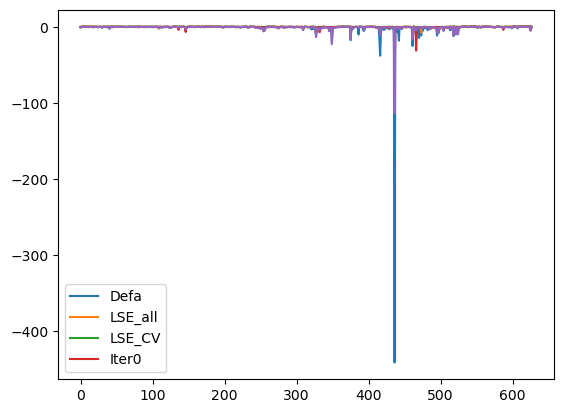

In [121]:
print(np.nanmedian(kge_all, axis=0))
plt.plot(kge_all)
plt.legend(['Defa',  'LSE_all',  'LSE_CV', 'Iter0'] )

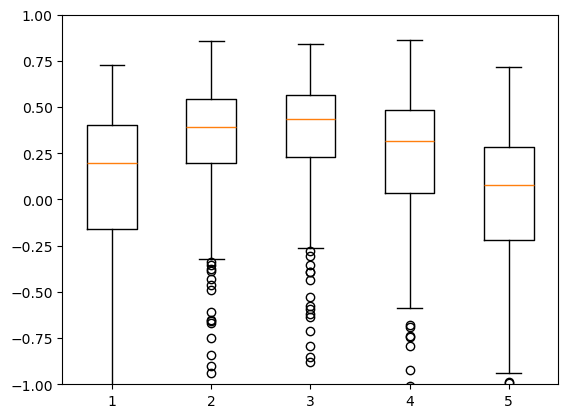

In [122]:
plt.boxplot(kge_all)
plt.ylim(-1, 1)

plt.show()

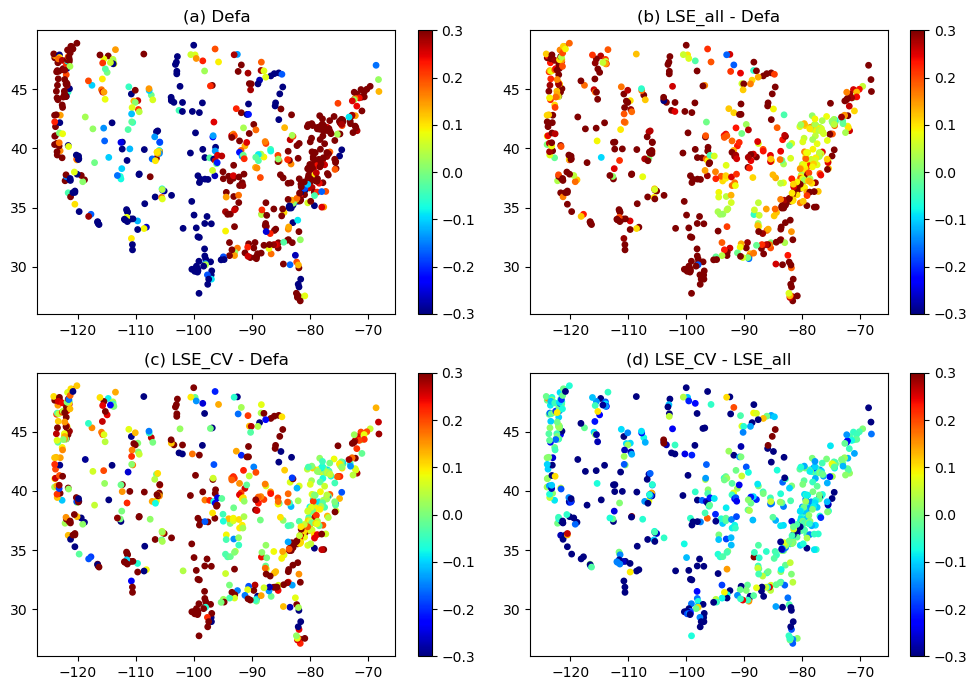

In [62]:
lon, lat = df_info['lon_cen'].values, df_info['lat_cen'].values
fig = plt.figure(figsize=[10, 7])

fig.add_subplot(2,2,1)
plt.scatter(lon, lat, 15, kge_all[:,0], cmap='jet', vmin=-0.3, vmax=0.3)
plt.colorbar()
plt.title('(a) Defa')

fig.add_subplot(2,2,2)
plt.scatter(lon, lat, 15, kge_all[:,1]-kge_all[:,0], cmap='jet', vmin=-0.3, vmax=0.3)
plt.colorbar()
plt.title('(b) LSE_all - Defa')

fig.add_subplot(2,2,3)
plt.scatter(lon, lat, 15, kge_all[:,2]-kge_all[:,0], cmap='jet', vmin=-0.3, vmax=0.3)
plt.colorbar()
plt.title('(c) LSE_CV - Defa')

fig.add_subplot(2,2,4)
plt.scatter(lon, lat, 15, kge_all[:,2]-kge_all[:,1], cmap='jet', vmin=-0.3, vmax=0.3)
plt.colorbar()
plt.title('(d) LSE_CV - LSE_all')

plt.tight_layout()
plt.show()

# analyze the performance of CV

In [60]:
import scipy
diff = kge_all[:,2]-kge_all[:,0]
scipy.stats.spearmanr(diff, kge_all[:,0])

SignificanceResult(statistic=-0.4822396620835913, pvalue=7.862481930193857e-38)

(-1.0, 1.0)

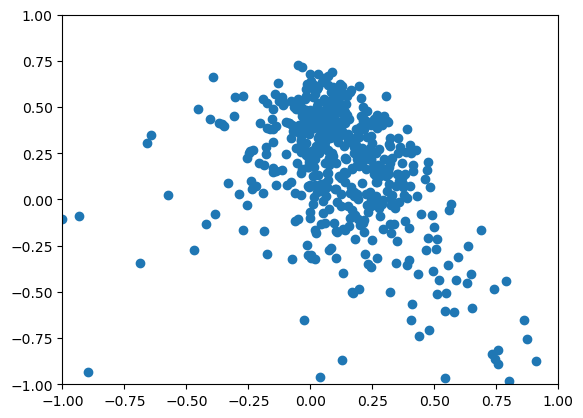

In [61]:
plt.scatter(kge_all[:,2]-kge_all[:,0], kge_all[:,0])
plt.xlim(-1,1)
plt.ylim(-1,1)

SignificanceResult(statistic=0.6778736686708271, pvalue=1.4700452916427744e-85)


(-1.0, 1.0)

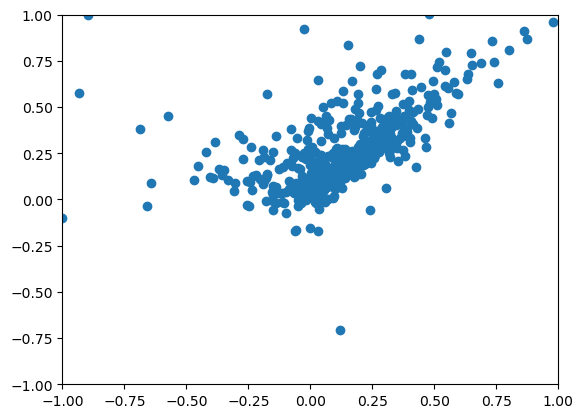

In [64]:
print(scipy.stats.spearmanr(kge_all[:,2]-kge_all[:,0], kge_all[:,1]-kge_all[:,0]))
plt.scatter(kge_all[:,2]-kge_all[:,0], kge_all[:,1]-kge_all[:,0])
plt.xlim(-1,1)
plt.ylim(-1,1)

## the correlation with CV emiulator performance

In [89]:

met = np.nan * np.zeros([len(df_info), 3]) # rmse/cc/mae
for i in range(5):
    filei = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LSE_spaceCV_PredictParam/RF_emulator_for_iter1_CVFold{i}_eval.npz'
    di = np.load(filei)
    y_test_pred=di['y_test_pred']
    y_test=np.squeeze(di['y_test'])
    basin_id=di['basin_id']

    for j in np.unique(basin_id):
        indj = basin_id == j
        met[j, 0] = get_rmse(y_test_pred[indj], y_test[indj])
        met[j, 1] = get_cc(y_test_pred[indj], y_test[indj])
        met[j, 2] = get_mae(y_test_pred[indj], y_test[indj])

print(np.sum(np.isnan(met), axis=0))

[0 0 0]


In [91]:
for i in range(3):
    print(scipy.stats.spearmanr(kge_all[:,1]-kge_all[:,0], met[:,i]))
    print(scipy.stats.spearmanr(kge_all[:,2]-kge_all[:,0], met[:,i]))

SignificanceResult(statistic=0.39794034722270233, pvalue=3.1838510035980184e-25)
SignificanceResult(statistic=0.06917488383441886, pvalue=0.08349562354730763)
SignificanceResult(statistic=-0.05087148405783611, pvalue=0.20333679492409198)
SignificanceResult(statistic=0.2592640608720011, pvalue=4.337827925030442e-11)
SignificanceResult(statistic=0.3757667249665035, pvalue=1.8448192204360518e-22)
SignificanceResult(statistic=0.05912422305154712, pvalue=0.1391915560845935)


In [92]:
for i in range(3):
    print(scipy.stats.spearmanr(kge_all[:,1], met[:,i]))
    print(scipy.stats.spearmanr(kge_all[:,2], met[:,i]))

SignificanceResult(statistic=-0.12684221139268323, pvalue=0.0014593349912523522)
SignificanceResult(statistic=-0.3434931744597058, pvalue=8.389240659971928e-19)
SignificanceResult(statistic=0.19068691020828749, pvalue=1.5133485507200736e-06)
SignificanceResult(statistic=0.3276524665037206, pvalue=3.713445723254497e-17)
SignificanceResult(statistic=-0.1134586453646859, pvalue=0.004447812869090128)
SignificanceResult(statistic=-0.32453761361822914, pvalue=7.626444008074756e-17)
